In [262]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm

In [263]:
# ==================================================================================================================== #
# choose product type {'f', 't', 'c'}
prod_type = 'c'

In [264]:
# ==================================================================================================================== #
# define projection
def projection(A, U, prod_type):
    training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
    return tp.ten_prod(U, training_coeff, prod_type=prod_type)

In [265]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [266]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data = scipy.io.loadmat('data-starplus-04847-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [267]:
print(np.transpose(labels).shape)
print(np.moveaxis(tensor_PS, -1, 0).shape)
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), np.transpose(labels), test_size=0.33, random_state=42)
print(training_data.shape)
(unique, counts) = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(training_labels, return_counts=True)
print(unique)
print(counts)

(80, 1)
(80, 64, 64, 8, 16)
(53, 64, 64, 8, 16)
[0. 1.]
[14 13]
[0. 1.]
[26 27]


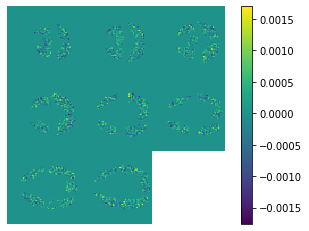

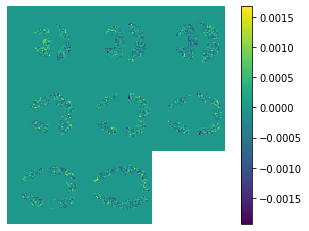

In [268]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [269]:
# move the label number to second axis
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)
print(training_data.shape)
print(test_data.shape)

(64, 53, 64, 8, 16)
(64, 27, 64, 8, 16)


In [270]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)

boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

[1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1.]


In [271]:
# ==================================================================================================================== #
# form local t-svd
# num_class should be 2
num_classes = len(np.unique(training_labels))
k = 5

U = []
print(num_classes)

for i in range(num_classes):
    u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type)
    U.append(u)

2


In [272]:
print(len(U))
print(type(U[0][0]))
print(U[1].shape)

2
<class 'numpy.ndarray'>
(64, 5, 64, 8, 16)


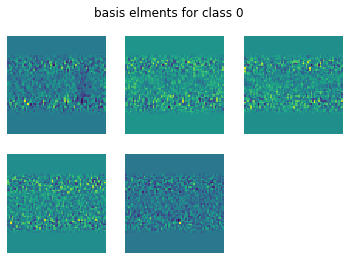

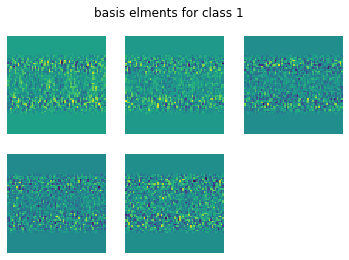

In [273]:
# visualizations
# use the existing tools or write your own!
for i in range(num_classes):
    slice_subplots(U[i][:, :, :, 0, 0], axis=1, title='basis elments for class ' + str(i))
    plt.show()

train accuracy = 100.00
test accuracy = 92.59


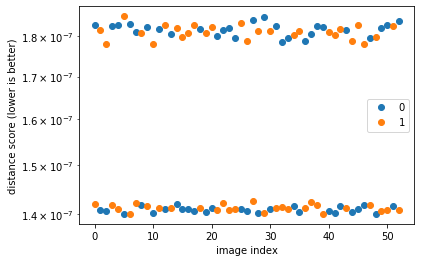

In [274]:
# ==================================================================================================================== #
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results

training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

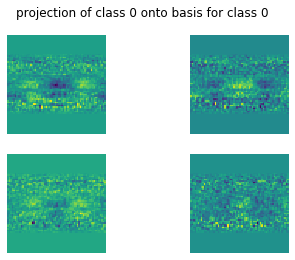

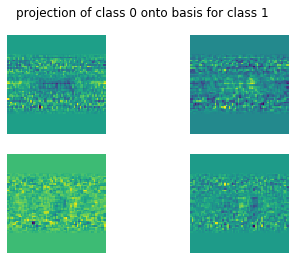

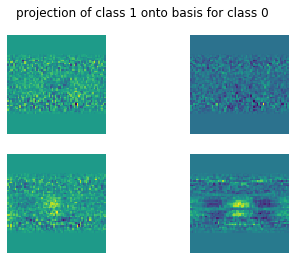

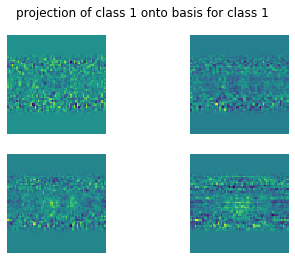

In [275]:
# ==================================================================================================================== #
# visualizations of projected tensors
# use the existing tools or write your own!

for j in range(num_classes):
    for i in range(num_classes):
        A = projection(np.moveaxis(training_data[:,boolean_array_training == j,:,0,0],-1,0), U[i][:, :, :, 0, 0], prod_type=prod_type)
        slice_subplots(A[:, :4, :], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()